# 3章Policy Function Iteration

In [364]:
# ライブラリのインポート
import numpy as np
from collections.abc import Callable
from scipy.optimize import fmin
from numpy.polynomial.chebyshev import Chebyshev
import copy
import matplotlib.pyplot as plt

### ステップ 1&2&3&4&5
1. グリッド生成
2. カリブレーションしたパラメータの値を設定
3. 収束の定義
4. 確率変数 $A = \{A_{good}, A_{bad}\}$を定義
5. 遷移確率行列 $P$を定義

In [365]:
# パラメータを定義したクラス
# 再代入されたりしないようにただの変数とは区別して定義する
class Parameters():
    '''
    モデルのパラメータをまとめたクラス
    '''
    def __init__(self, beta: float, gamma: float, alpha: float, delta: float,
                A: np.ndarray, P: np.ndarray,
                kmax: float, kmin: float, ksize: int,
                epsilon: float, max_iter: int):
        self.beta = beta; self.gamma = gamma; self.alpha = alpha; self.delta = delta
        self.A = A; self.P = P
        self.kmax = kmax; self.kmin = kmin; self.ksize = ksize
        self.epsilon = epsilon; self.max_iter = max_iter
        self.k_grid = np.linspace(start = self.kmin, stop = self.kmax, num  = self.ksize)

In [366]:
params = Parameters(alpha = 0.4, beta = 0.96, gamma = 1.0, delta = 1.0,
                    kmax = 0.5, kmin = 0.025, ksize = 20,
                    epsilon = 1e-5, max_iter = 1000,
                    A = np.array([1.01, 0.99]),
                    P = np.array([[0.875, 0.125],[0.125, 0.875]]),
                    )

### ステップ6. 政策関数$k'=g^{[0]}(k_i,z_l)$をguess

- 今回は富の関数の半分の値とする

In [367]:
# 富の関数
def wealth(params: Parameters, k: float, a: float) -> float:
    return a * (k**params.alpha) + (1 - params.delta) * k

In [368]:
kprime_g0_grid = np.zeros((params.ksize, params.A.size))
for i, k in enumerate(params.k_grid):
    for l, a in enumerate(params.A):
        kprime_g0_grid[i, l] = wealth(params, k, a) / 2
print(kprime_g0_grid)

[[0.11546953 0.113183  ]
 [0.15236295 0.14934586]
 [0.17919087 0.17564254]
 [0.20104412 0.19706305]
 [0.21981402 0.21546126]
 [0.23644377 0.23176172]
 [0.25148182 0.24650198]
 [0.26527931 0.26002625]
 [0.27807656 0.2725701 ]
 [0.29004633 0.28430284]
 [0.30131757 0.29535088]
 [0.31198943 0.30581142]
 [0.32214005 0.31576104]
 [0.33183225 0.32526132]
 [0.34111741 0.33436261]
 [0.35003815 0.3431067 ]
 [0.35863028 0.35152869]
 [0.36692422 0.3596584 ]
 [0.37494608 0.36752141]
 [0.38271843 0.37513985]]


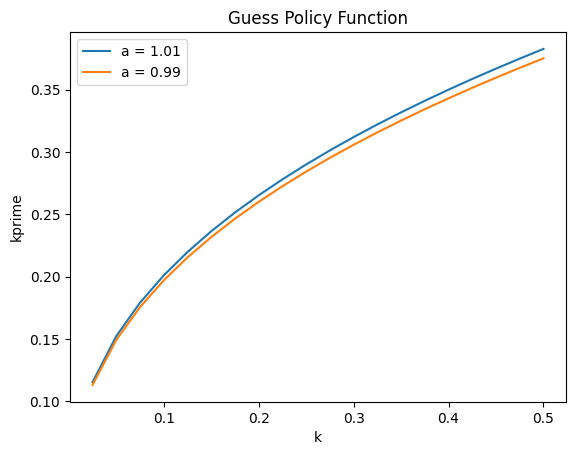

In [369]:
# guess した政策関数を確認するためにプロット
fig, ax = plt.subplots()
for l, a in enumerate(params.A):
    ax.plot(params.k_grid, kprime_g0_grid[:, l], label = f"a = {a}")
ax.set(xlabel = 'k', ylabel = 'kprime', title = 'Guess Policy Function')
ax.legend()
plt.show()

### ステップ7. 当て推量した政策関数を用いて価値関数を計算する

In [370]:
# 効用関数
def utility(params: Parameters, c: float):
    if params.gamma == 1.0:
        return np.log(c)

    return (c ** (1 - params.gamma)) / (1 - params.gamma)

In [371]:
# utility関数のテスト あっていれば何も出力されない
assert utility(params, 1.0) == 0.0
assert utility(params, 2.0) == np.log(2.0)
assert utility(params, 0.5) == np.log(0.5)

In [372]:
# ベルマン方程式の右辺
def rhs_bellman(params: Parameters, wealth: float, kprime: float, a: float,
                utility: Callable, vf: Callable[[float, float], float]):
    Aidx = np.where(params.A == a)[0][0]
    for k, aprime in enumerate(params.A):
        expected_vf =+ params.P[Aidx, k] * vf(kprime, aprime)
    rhs = utility(params, wealth - kprime) + params.beta * expected_vf
    return rhs

In [387]:
# rhs_bellmanのテスト
assert rhs_bellman(params, 1.0, 0.5, 1.01, utility, lambda x, y: 0.0) == np.log(0.5)
assert rhs_bellman(params, 1.0, 0.5, 0.99, utility, lambda x, y: 0.0) == np.log(0.5)

In [374]:
# 政策関数を所与として価値関数を更新する関数
def update_vf(params: Parameters, loops: int, pf_grid: np.ndarray, utility: Callable,
                wealth: Callable, rhs_bellman: Callable,
                vf_old: Callable[[float, float], float]):
    vf_new_grid = np.zeros((params.ksize, params.A.size))
    for loop in range(loops): 
        for i, K in enumerate(params.k_grid):
            for l, a in enumerate(params.A):
                vf_new_grid[i, l] = rhs_bellman(params, wealth(params, K, a), pf_grid[i, l], a, utility, vf_old)
        def vf_new(k:float, a: float) -> float:
            # aと一致する要素のインデックスを取得
            Aidx = np.where(params.A == a)[0][0]
            vf_new = Chebyshev.fit(params.k_grid, vf_new_grid[:, Aidx], deg=15)
            return vf_new(k)
        vf_old = copy.copy(vf_new)
    return vf_new

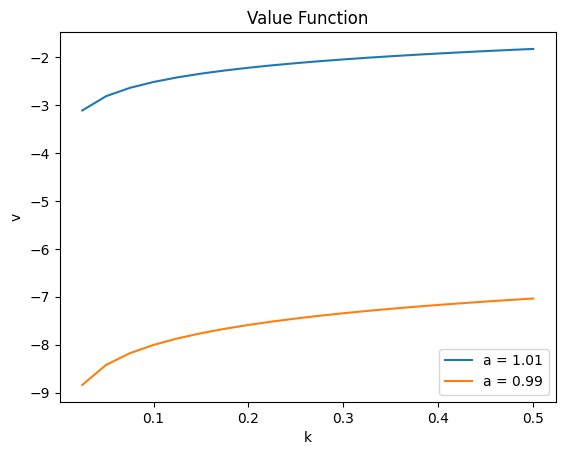

In [375]:
# 政策関数を所与として価値関数を更新する関数を確認のためにプロット
vf_test = update_vf(params, 1000, kprime_g0_grid, utility, wealth, rhs_bellman, lambda x, y: 0.0)
fig, ax = plt.subplots()
for l, a in enumerate(params.A):
    ax.plot(params.k_grid, [vf_test(k, a) for k in params.k_grid], label = f"a = {a}")
ax.set(xlabel = 'k', ylabel = 'v', title = 'Value Function')
ax.legend()
plt.show()

In [376]:
# 価値関数を所与として政策関数を更新する関数
def update_pf(params: Parameters, calc_wealth: Callable,
            rhs_bellman: Callable, utility: Callable, vf: Callable):
    pf_new_grid = np.zeros((params.ksize, params.A.size))
    
    def wrap_rhs_bellman(kprime: float, params: Callable, wealth: float,
                        a: float, utility: Callable, vf: Callable):
        if wealth < kprime: # 消費が負になる場合はペナルティを与える
            return 10**5 + kprime
        return - rhs_bellman(params, wealth, kprime, a, utility, vf)
    
    for i, K in enumerate(params.k_grid):
        for l, a in enumerate(params.A):
            wealth = calc_wealth(params, K, a)
            pf_new_grid[i, l] = fmin(wrap_rhs_bellman,
                                    x0 = [params.k_grid[i]],
                                    args = (params, wealth, a, utility, vf),
                                    disp=False)
    return pf_new_grid

/var/folders/y2/hwl07kg14b31nb5s126cjc8m0000gn/T/ipykernel_97465/1695087913.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pf_new_grid[i, l] = fmin(wrap_rhs_bellman,


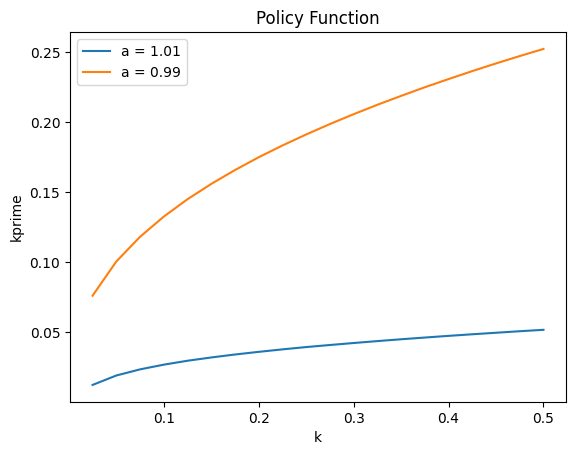

In [379]:
# 政策関数を所与として価値関数を更新する関数を確認のためにプロット
params.A = np.array([1.01, 0.99])
pf_test = update_pf(params, wealth, rhs_bellman, utility, vf_test)
fig, ax = plt.subplots()
for l, a in enumerate(params.A):
    ax.plot(params.k_grid, pf_test[:, l], label = f"a = {a}")
ax.set(xlabel = 'k', ylabel = 'kprime', title = 'Policy Function')
ax.legend()
plt.show()

In [381]:
# 収束の計算をする関数
def is_converged(params: Parameters, vf_old, vf_new):
    np_vf_old = np.frompyfunc(vf_old, 2, 1)
    np_vf_new = np.frompyfunc(vf_new, 2, 1)
    # k_grid行A列の行列を生成
    KK, AA = np.meshgrid(params.k_grid, params.A, indexing = "ij")
    vf_old_grid = np_vf_old(KK, AA)
    vf_new_grid = np_vf_new(KK, AA)
    diff = np.max(np.abs(vf_new_grid - vf_old_grid))
    print(diff)
    if diff < params.epsilon:
        return True
    return False

In [382]:
def PFI(params: Parameters, update_vf: Callable, update_pf: Callable,
        is_converged: Callable, utility: Callable, wealth: Callable, rhs_bellman: Callable, 
        kprime_g0_grid):
    # 価値関数の当て推量
    vf_old = lambda k, a: 0
    vf_new = lambda k, a: 1

    kprime_g1_grid = np.zeros((params.k_grid.size, params.A.size))
    
    loop = 0
    while is_converged(params, vf_old, vf_new) != True:

        vf_old = copy.copy(vf_new)
        # 当て推量した政策関数を用いて, 価値関数を計算
        vf_new = update_vf(params, params.max_iter, kprime_g0_grid, utility,
                            wealth, rhs_bellman, vf_old)
        
        # 新しい価値関数を用いて政策関数を計算する
        kprime_g1_grid = update_pf(params, wealth, rhs_bellman, utility, vf_new)
        
        # 新しく得られた政策関数を用いて価値関数を再計算する
        vf_new = update_vf(params, params.max_iter, kprime_g1_grid, utility,
                            wealth, rhs_bellman, vf_new)
        
        kprime_g0_grid = kprime_g1_grid
        loop += 1
        print(f'loops {loop}')

    return vf_new, kprime_g1_grid, params

In [383]:
vf_new, kprime_g1_grid, params = PFI(params, update_vf, update_pf, is_converged, utility,
                                    wealth, rhs_bellman, kprime_g0_grid)

1


/var/folders/y2/hwl07kg14b31nb5s126cjc8m0000gn/T/ipykernel_97465/1695087913.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pf_new_grid[i, l] = fmin(wrap_rhs_bellman,


loops 1
9.325355698583492
loops 2
9.767095265900139e-08


In [384]:
print(kprime_g1_grid)

[[0.01226563 0.07601563]
 [0.0190625  0.10039063]
 [0.0234375  0.11800781]
 [0.02679688 0.13242188]
 [0.02958984 0.14482422]
 [0.03193359 0.15574219]
 [0.03404297 0.16563477]
 [0.0359375  0.17476563]
 [0.03770508 0.18316406]
 [0.03935547 0.19101562]
 [0.04082031 0.19846191]
 [0.04224609 0.20548828]
 [0.0436084  0.21220215]
 [0.04491211 0.21854492]
 [0.04614258 0.22470703]
 [0.04734375 0.23054688]
 [0.04847656 0.23624023]
 [0.04957031 0.24169922]
 [0.0506543  0.24696289]
 [0.05166016 0.25205078]]


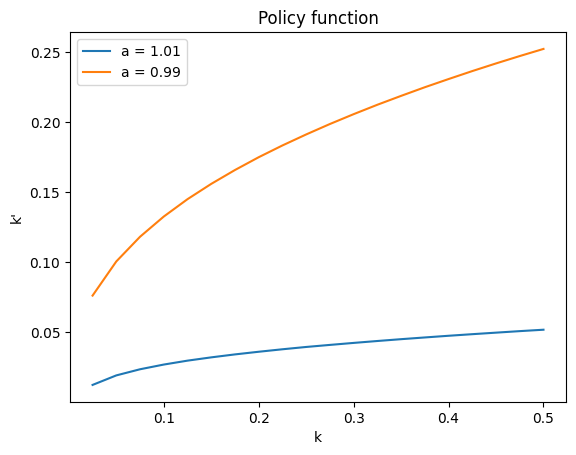

In [385]:
# kprime_g1_grid をプロット
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i, a in enumerate(params.A):
    ax.plot(params.k_grid, kprime_g1_grid[:, i], label = f"a = {a}")
ax.set(xlabel = "k", ylabel = "k'", title = "Policy function")
ax.legend()
plt.show()

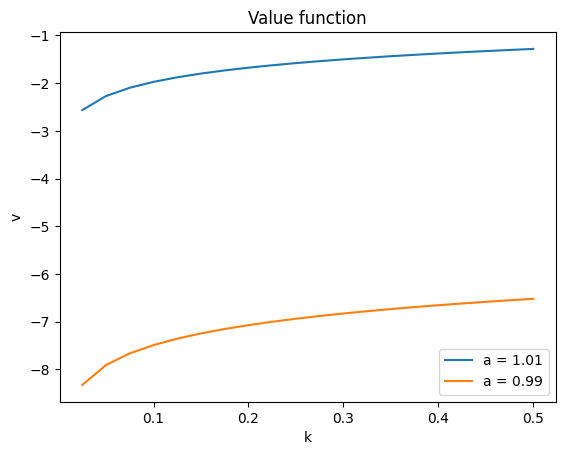

In [386]:
# 収束後の価値関数をプロット
fig, ax = plt.subplots()
for i, a in enumerate(params.A):
    ax.plot(params.k_grid, [vf_new(k, a) for k in params.k_grid], label = f"a = {a}")
ax.set(xlabel = "k", ylabel = "v", title = "Value function")
ax.legend()
plt.show()

### p78 図3.6の価値関数と政策関数をプロット

In [362]:
%reset -f